In [3]:
import tensorflow as tf
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import drive
import os

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/waverityDataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_50_2.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_50_3.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_50_4.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_50_5.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_50_6.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_50_7.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_51_0.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncrack_noncrack_concrete_wall_51_1.jpg.jpg  
  inflating: Conglomerate Concrete Crack Detection/Train/masks/noncra

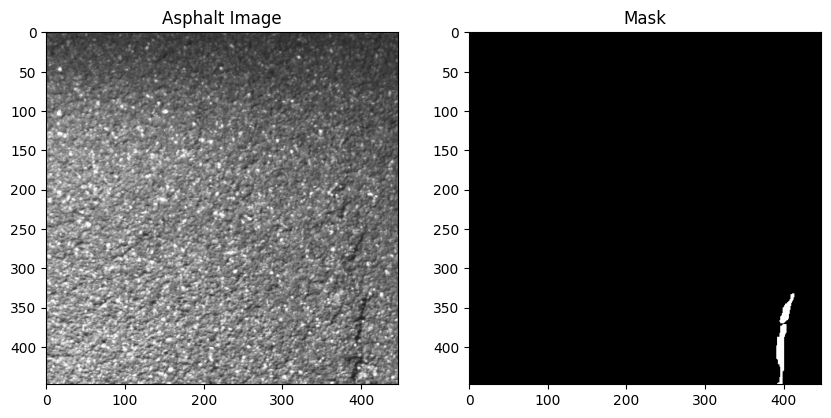

In [4]:
import matplotlib.pyplot as plt
import cv2
import os

img_path = '/content/waverityDataset/Train/images'
mask_path = '/content/waverityDataset/Train/masks'

img_files = os.listdir(img_path)
mask_files = os.listdir(mask_path)
random_image_number = random.randint(0, len(img_files))

# Visualizing a random image and its mask
img = cv2.imread(os.path.join(img_path, img_files[random_image_number]))
mask = cv2.imread(os.path.join(mask_path, mask_files[random_image_number]), 0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title('Asphalt Image')
axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')
plt.show()

In [5]:
def resize_images_and_masks(image_dir, mask_dir, new_size=(64, 64)):
    resized_images = []
    resized_masks = []

    # Iterate through the image and mask directories
    for image_file, mask_file in zip(sorted(os.listdir(image_dir)), sorted(os.listdir(mask_dir))):
        # Load image and mask
        image = cv2.imread(os.path.join(image_dir, image_file))
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)

        # Resize image and mask
        resized_image = cv2.resize(image, new_size)
        resized_mask = cv2.resize(mask, new_size)

        resized_images.append(resized_image)
        resized_masks.append(resized_mask)

    # Convert lists to numpy arrays
    resized_images = np.array(resized_images)
    resized_masks = np.array(resized_masks)

    return resized_images, resized_masks

# Example usage
image_dir = "/content/waverityDataset/Train/images"
mask_dir = "/content/waverityDataset/Train/masks"
resized_images, resized_masks = resize_images_and_masks(image_dir, mask_dir, new_size=(128, 128))

In [6]:

resized_images.shape

(9899, 128, 128, 3)

In [7]:
resized_masks.shape

(9899, 128, 128)

In [8]:
resized_masks[0][40]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  0,  1,  0, 49,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=uint8)

In [9]:
train_images = resized_images / 255.0
train_mask = resized_masks / 255.0


In [10]:
train_masks_expanded = np.expand_dims(train_mask, axis = 3)
train_masks_expanded.shape

(9899, 128, 128, 1)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding = "same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding = "same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = "same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_unet(input_shape, n_classes):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 128)
  s2, p2 = encoder_block(p1, 256)
  s3, p3 = encoder_block(p2, 512)
  s4, p4 = encoder_block(p3, 1024)

  b1 = conv_block(p4, 1024)

  d1 = decoder_block(b1, s4, 1024)
  d2 = decoder_block(d1, s3, 512)
  d3 = decoder_block(d2, s2, 256)
  d4 = decoder_block(d3, s1, 128)

  if n_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'

  outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
  print(activation)

  model = Model(inputs, outputs, name="U-Net")
  return model

In [12]:
input_shape = (128, 128, 3)

In [13]:
model = build_unet(input_shape, n_classes = 1)
model.compile(optimizer = Adam(learning_rate = 1e-3), loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

sigmoid


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 128)  │          3,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 128)  │            512 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 128)  │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 256)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 256)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 82,203,521 (313.58 MB)

 Trainable params: 82,184,065 (313.51 MB)

 Non-trainable params: 19,456 (76.00 KB)

In [14]:
train_masks_expanded = (train_masks_expanded > 0.5).astype(np.float32)


In [15]:
test_image_path = "/content/waverityDataset/Test/images"
test_mask_path = "/content/waverityDataset/Test/masks"
resized_test_images, resized_test_masks = resize_images_and_masks(test_image_path, test_mask_path, new_size = (128, 128))
test_images = resized_test_images / 255.0
test_masks = resized_test_masks / 255.0
test_masks_expanded = np.expand_dims(test_masks, axis = 3)
test_masks_expanded = (test_masks_expanded > 0.5).astype(np.float32)

In [17]:
history_1 = model.fit(train_images, train_masks_expanded,
                      batch_size = 16,
                      verbose = 1,
                      epochs = 1,
                      validation_data = (test_images, test_masks_expanded),
                      shuffle = False)

619/619 ━━━━━━━━━━━━━━━━━━━━ 13899s 22s/step - accuracy: 0.9687 - loss: 0.0926 - val_accuracy: 0.9717 - val_loss: 0.1810


In [18]:
model.evaluate(test_images, test_masks_expanded)

35/35 ━━━━━━━━━━━━━━━━━━━━ 401s 11s/step - accuracy: 0.9578 - loss: 0.2639


[0.18097950518131256, 0.9717071056365967]

In [19]:
# Apply thresholding: all pixels > 127 will become 255, others 0
_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

# Now only pixels with 255 are considered cracks
crack_coords = np.column_stack(np.where(binary_mask == 255))

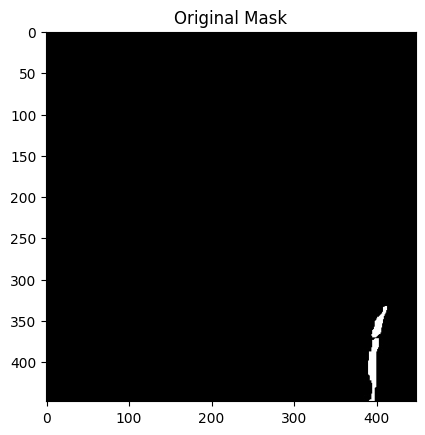

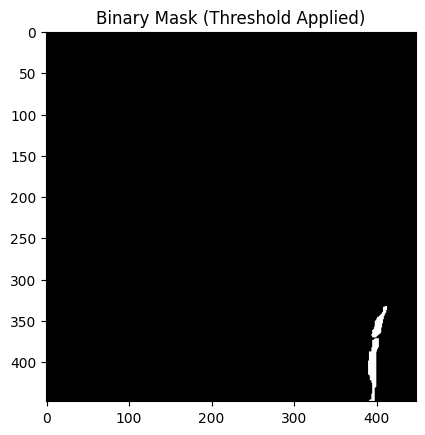

In [20]:
# Visualize the original mask
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')
plt.show()

# Visualize the binary mask after thresholding
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask (Threshold Applied)')
plt.show()

In [21]:
unique_pixels = np.unique(binary_mask)
print(unique_pixels)

[  0 255]


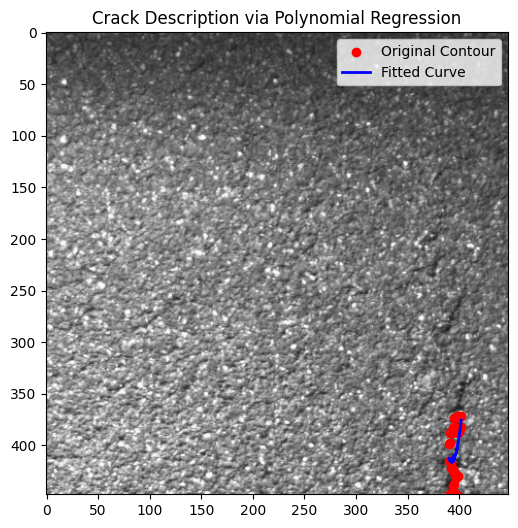

Crack Equation: -74263.50 + 380.20*x^1 + -0.48*x^2


In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Function to extract contours from the mask
def extract_contour_from_mask(mask_image):
    # Convert to grayscale if necessary
    if len(mask_image.shape) == 3:
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)

    # Find contours
    contours, _ = cv2.findContours(mask_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming there's one main contour (the crack), you can take the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Convert contour to numpy array for processing
    contour_points = largest_contour[:, 0, :]
    return contour_points

# Function to fit polynomial regression
def fit_polynomial_regression(contour_points, degree=2):
    # Extract x and y coordinates from the contour points
    x = contour_points[:, 0].reshape(-1, 1)
    y = contour_points[:, 1].reshape(-1, 1)

    # Apply polynomial features
    poly = PolynomialFeatures(degree)
    x_poly = poly.fit_transform(x)

    # Fit linear regression
    model = LinearRegression()
    model.fit(x_poly, y)

    # Predict the curve
    y_pred = model.predict(x_poly)

    # Return model and predictions
    return model, y_pred, x, y, poly

# Function to visualize results
def plot_results(x, y, y_pred, image, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap='gray')
    plt.scatter(x, y, color='red', label='Original Contour')
    plt.plot(x, y_pred, color='blue', linewidth=2, label='Fitted Curve')
    plt.title(title)
    plt.legend()
    plt.show()

# Load sample image and corresponding mask
def get_polynomial_equation(model, poly):
    coefs = model.coef_[0]
    intercept = model.intercept_[0]

    # Build the equation as a string
    equation_terms = [f"{intercept:.2f}"]
    for i, coef in enumerate(coefs[1:], 1):  # Skip the first coefficient (for x^0)
        equation_terms.append(f"{coef:.2f}*x^{i}")

    # Join the terms to form the equation
    equation = " + ".join(equation_terms)
    return equation


# Extract crack contour
contour_points = extract_contour_from_mask(binary_mask)

# Fit polynomial regression (for example, degree 2)
model, y_pred, x, y, poly= fit_polynomial_regression(contour_points, degree=2)

# Plot the results
plot_results(x, y, y_pred, img, 'Crack Description via Polynomial Regression')

# You can print the coefficients of the model
equation = get_polynomial_equation(model, poly)
print("Crack Equation:", equation)

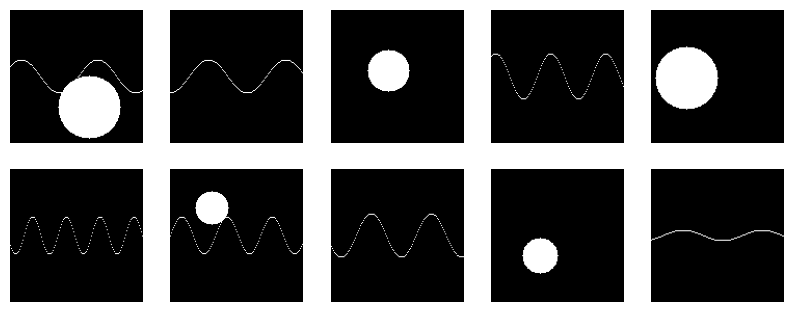

In [23]:
# Function to generate a circle crack
def generate_circle_crack(image_size, center, radius):
    Y, X = np.ogrid[:image_size, :image_size]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    mask = dist_from_center <= radius
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    image[mask] = 1  # Set pixels inside the circle to 1
    return image

# Function to generate a sine wave crack
def generate_sine_crack(image_size, amplitude, frequency, phase_shift):
    X = np.arange(image_size)
    Y = amplitude * np.sin(frequency * X + phase_shift) + image_size // 2
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    for x, y in zip(X, Y.astype(int)):
        if 0 <= y < image_size:
            image[y, x] = 1
    return image

# Function to combine multiple cracks into one image
def combine_cracks(image1, image2):
    return np.maximum(image1, image2)  # Combine images by taking the maximum pixel value

# Function to generate synthetic binary images
def generate_synthetic_images(num_images=10, image_size=128):
    images = []
    for i in range(num_images):
        if i % 2 == 0:
            # Generate circle cracks
            center = (np.random.randint(image_size//4, 3*image_size//4), np.random.randint(image_size//4, 3*image_size//4))
            radius = np.random.randint(image_size//8, image_size//4)
            image = generate_circle_crack(image_size, center, radius)
        else:
            # Generate sine wave cracks
            amplitude = np.random.randint(5, image_size//4)
            frequency = np.random.uniform(0.05, 0.2)
            phase_shift = np.random.uniform(0, 2*np.pi)
            image = generate_sine_crack(image_size, amplitude, frequency, phase_shift)

        # Sometimes combine multiple cracks
        if np.random.rand() > 0.5:
            additional_crack = generate_sine_crack(image_size, np.random.randint(5, image_size//4), np.random.uniform(0.05, 0.2), np.random.uniform(0, 2*np.pi))
            image = combine_cracks(image, additional_crack)

        images.append(image)

    return images

# Function to visualize the generated images
def visualize_images(images):
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.show()

# Generate 10 synthetic binary images
synthetic_images = generate_synthetic_images(10)

# Visualize the generated images
visualize_images(synthetic_images)

In [24]:
from scipy.optimize import curve_fit

# Function to fit a sine wave to crack points
def sine_function(x, A, B, C):
    return A * np.sin(B * x + C)

# Function to extract crack points from a binary image
def extract_crack_points(image):
    y_coords, x_coords = np.where(image == 1)  # Find pixels with value 1 (the crack)
    return x_coords, y_coords

# Fit a sine wave to the extracted crack points
def fit_sine_wave(x_coords, y_coords):
    # Initial guess for sine parameters [amplitude, frequency, phase shift]
    initial_guess = [20, 0.1, 0]

    # Fit sine wave using non-linear least squares
    params, _ = curve_fit(sine_function, x_coords, y_coords, p0=initial_guess)

    return params  # Amplitude, Frequency, Phase Shift

# Function to fit a circle to crack points using least squares
def fit_circle(x_coords, y_coords):
    def circle_equation(params, x, y):
        x0, y0, r = params
        return (x - x0)**2 + (y - y0)**2 - r**2

    # Initial guess for circle center and radius
    x0, y0 = np.mean(x_coords), np.mean(y_coords)
    r0 = np.sqrt(np.max((x_coords - x0)**2 + (y_coords - y0)**2))

    # Use least squares to fit the circle
    from scipy.optimize import least_squares
    params_initial = [x0, y0, r0]
    result = least_squares(circle_equation, params_initial, args=(x_coords, y_coords))

    return result.x  # Center (x0, y0) and radius r


# Assume you have a synthetic binary image with sine wave cracks
image_size = 128
synthetic_image = generate_sine_crack(image_size, amplitude=20, frequency=0.1, phase_shift=0)  # Generate an image

# Extract crack points
x_coords, y_coords = extract_crack_points(synthetic_image)

# Fit sine wave
sine_params = fit_sine_wave(x_coords, y_coords)
print(f"Fitted Sine Wave Parameters (Amplitude, Frequency, Phase Shift): {sine_params}")

# Compare the fitted sine wave parameters with the original ones
original_sine_params = [20, 0.1, 0]
print(f"Original Sine Wave Parameters: {original_sine_params}")

# Similarly, for circular cracks, fit a circle and compare
synthetic_circle_image = generate_circle_crack(image_size, center=(64, 64), radius=30)  # Generate a circle crack

# Extract crack points
x_coords_circle, y_coords_circle = extract_crack_points(synthetic_circle_image)

# Fit circle
circle_params = fit_circle(x_coords_circle, y_coords_circle)
print(f"Fitted Circle Parameters (x0, y0, radius): {circle_params}")

# Compare the fitted circle parameters with the original ones
original_circle_params = [64, 64, 30]
print(f"Original Circle Parameters: {original_circle_params}")


Fitted Sine Wave Parameters (Amplitude, Frequency, Phase Shift): [22.76917607  0.11393172 -0.22894178]
Original Sine Wave Parameters: [20, 0.1, 0]
Fitted Circle Parameters (x0, y0, radius): [64.         64.         21.18967865]
Original Circle Parameters: [64, 64, 30]


In [25]:
##### With 2 of the 10 images

# Let's assume 'synthetic_images' contains the 10 previously generated images
# and that you generated them using the `generate_synthetic_images()` function.

# Select one image that contains a sine crack and one that contains a circular crack
# For example:
sine_image = synthetic_images[1]  # This should correspond to a sine wave crack
circle_image = synthetic_images[0]  # This should correspond to a circle crack

# Extract crack points from the sine wave image
x_coords_sine, y_coords_sine = extract_crack_points(sine_image)

# Fit a sine wave to the extracted points
sine_params = fit_sine_wave(x_coords_sine, y_coords_sine)
print(f"Fitted Sine Wave Parameters (Amplitude, Frequency, Phase Shift): {sine_params}")

# Compare the fitted sine wave parameters with the original ones
# If you know the parameters used to generate sine_image, input them here
original_sine_params = [20, 0.1, 0]  # Example values, replace with actual ones
print(f"Original Sine Wave Parameters: {original_sine_params}")

# Extract crack points from the circle image
x_coords_circle, y_coords_circle = extract_crack_points(circle_image)

# Fit a circle to the extracted points
circle_params = fit_circle(x_coords_circle, y_coords_circle)
print(f"Fitted Circle Parameters (x0, y0, radius): {circle_params}")

# Compare the fitted circle parameters with the original ones
# If you know the parameters used to generate circle_image, input them here
original_circle_params = [64, 64, 30]  # Example values, replace with actual ones
print(f"Original Circle Parameters: {original_circle_params}")



Fitted Sine Wave Parameters (Amplitude, Frequency, Phase Shift): [20.17068869  0.11651823  0.18741495]
Original Sine Wave Parameters: [20, 0.1, 0]
Fitted Circle Parameters (x0, y0, radius): [71.15683012 87.3082643  24.01656734]
Original Circle Parameters: [64, 64, 30]
